# Example: Branches in 3D Horse

This notebook demonstrates how FLASC behaves on a 3D point cloud of a horse. 
This point cloud consists of 3D points sampled from the surface of a horse. 
The sampling density varies with the level of detail on the surface. For example, 
there are a lot more points on the head than on the stomach. In addition, the 
data-set has several hollow regions, which FLASC's centrality metric has to deal 
with accurately.

The horse-shaped mesh-reconstructionn dataset is obtained from [a STAD
repository](https://github.com/vda-lab/pySTAD). The meshes were originally
created or adapted for a paper by [Robert W. Sumner and Jovan Popovic
(2004)](https://dl.acm.org/doi/10.1145/1015706.1015736#d17686678e1). They
can be downloaded and are described in more detail on [their
website](https://people.csail.mit.edu/sumner/research/deftransfer/data.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from flasc import FLASC

from _plotting import *
palette = configure_matplotlib()

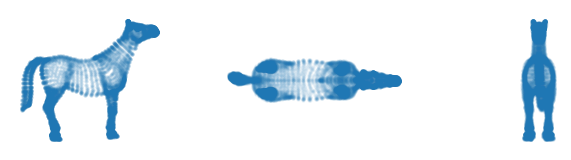

In [2]:
df = pd.read_csv('./data/horse.csv')
X = df.to_numpy()

sized_fig(1, aspect=0.618/3)
plt.subplot(1, 3, 1)
plt.scatter(X.T[2], X.T[1], 1, alpha=0.1)
frame_off()
plt.subplot(1, 3, 2)
plt.scatter(X.T[2], X.T[0], 1, alpha=0.1)
frame_off()
plt.subplot(1, 3, 3)
plt.scatter(X.T[0], X.T[1], 1, alpha=0.1)
frame_off()
plt.show()

## Single cluster

First, lets analyze this dataset as if it is a single cluster. For that purpose, 
we set `override_cluster_labels` to assign every point to the `0` cluster. This 
is different from `allow_single_cluster`, as it gives each point the same cluster 
membership probability. All branches in this point cloud (legs, head, and tail) 
are quite large, so we set `min_branch_size=20`. Because there are no noise 
points and to speed up the result, we keep `min_samples=5`. Note that this value 
is unlikely to cross the hollow regions in the legs and torso.

In [3]:
c = FLASC(
    override_cluster_labels=np.zeros(X.shape[0], dtype=np.intp),
    min_samples=5,
    min_branch_size=20,
    branch_selection_method='leaf',
).fit(X)
g = c.cluster_approximation_graph_

With these settings, we find 2 main sides of the cluster, with 3 persistent branches each.

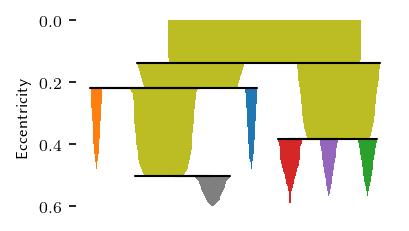

In [4]:
sized_fig()
c.cluster_condensed_trees_[0].plot(leaf_separation=0.2)
plt.ylabel('Eccentricity')
plt.show()

The resulting branches neatly correspond to the legs, head, ears and tail.
The torso gets its own label, indicating the most central points.

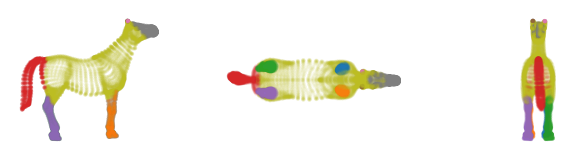

In [5]:
sized_fig(1, aspect=0.618/3)
plt.subplot(1, 3, 1)
plt.scatter(X.T[2], X.T[1], 1, c.labels_, 
            alpha=0.1, cmap='tab10', vmax=10)
frame_off()
plt.subplot(1, 3, 2)
plt.scatter(X.T[2], X.T[0], 1, c.labels_, 
            alpha=0.1, cmap='tab10', vmax=10)
frame_off()
plt.subplot(1, 3, 3)
plt.scatter(X.T[0], X.T[1], 1, c.labels_,
            alpha=0.1, cmap='tab10', vmax=10)
frame_off()
plt.show()

Computing the branch membership vectors to re-assign central points
to the closest branch centroid in the cluster approximation graph 
lets each branch grow into the torso for a potentially more useful 
segmentation.

In [6]:
from flasc.prediction import branch_centrality_vectors, update_labels_with_branch_centrality

v = branch_centrality_vectors(c)
l, _ = update_labels_with_branch_centrality(c, v)

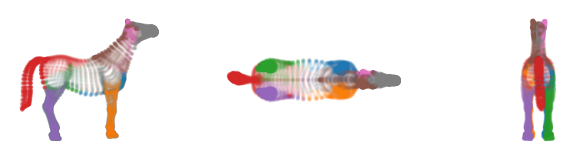

In [7]:
sized_fig(1, aspect=0.618/3)
plt.subplot(1, 3, 1)
plt.scatter(X.T[2], X.T[1], 1, l, 
            alpha=0.1, cmap='tab10', vmax=10)
frame_off()
plt.subplot(1, 3, 2)
plt.scatter(X.T[2], X.T[0], 1, l, 
            alpha=0.1, cmap='tab10', vmax=10)
frame_off()
plt.subplot(1, 3, 3)
plt.scatter(X.T[0], X.T[1], 1, l,
            alpha=0.1, cmap='tab10', vmax=10)
frame_off()
plt.show()

## Multiple clusters

This data set can also be viewed as multiple density-based clusters. To 
cluster this dataset we specify `min_samples=20` and `min_cluster_size=1000`. 
This results in four clusters: the tail, the head, the back legs, and the front 
legs. Parts of the torse are classified as noise. To detect branches within 
these clusters, we set `min_branch_size=20` and `branch_selection_persistence=0.1`.

In [8]:
c = FLASC(
    min_samples=20, 
    min_cluster_size=1000, 
    min_branch_size=20,
    branch_selection_persistence=0.1
).fit(X)
g = c.cluster_approximation_graph_

The clustering found 2 sides the each contain 2 clusters.

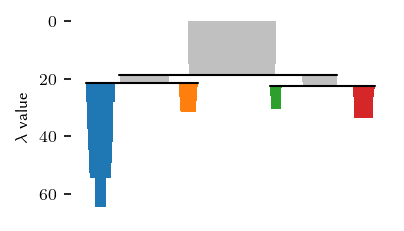

In [9]:
sized_fig()
c.condensed_tree_.plot()
plt.show()

The resulting clusters neatly capture the tail, back legs, front legs and head.

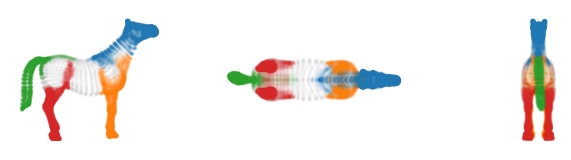

In [10]:
sized_fig(1, aspect=0.618/3)
plt.subplot(1, 3, 1)
colors = [palette[l]  if l >= 0 else (0.8, 0.8, 0.8) for l in c.cluster_labels_]
plt.scatter(X.T[2], X.T[1], 1, colors, 
            alpha=0.1)
frame_off()
plt.subplot(1, 3, 2)
plt.scatter(X.T[2], X.T[0], 1, colors, 
            alpha=0.1)
frame_off()
plt.subplot(1, 3, 3)
plt.scatter(X.T[0], X.T[1], 1, colors,
            alpha=0.1)
frame_off()
plt.show()

The branches detect the individual lower-legs, hips and shoulder-region as
distinct branches.

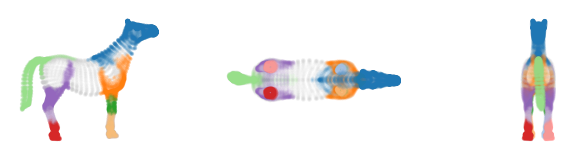

In [11]:
sized_fig(1, aspect=0.618/3)
palette = plt.get_cmap('tab20').colors
plt.subplot(1, 3, 1)
colors = [
    palette[l]  if l >= 0 else (0.8, 0.8, 0.8) 
    for l in c.labels_
]
plt.scatter(X.T[2], X.T[1], 1, colors, 
            alpha=0.1)
frame_off()
plt.subplot(1, 3, 2)
plt.scatter(X.T[2], X.T[0], 1, colors, 
            alpha=0.1)
frame_off()
plt.subplot(1, 3, 3)
plt.scatter(X.T[0], X.T[1], 1, colors,
            alpha=0.1)
frame_off()
plt.show()

The branch grouping is easier to see when drawn over the cluster approximation 
graphs. A potential issue with this segmentation is that the label for the
most central points in the front-legs consists of two distinct 
connected component. This happens for U-shaped clusters in general, where the 
centroid lies between the branches, and both branches have a local centrality 
maximum.

C:\Users\jelme\Documents\Development\work\flasc\pyflasc\flasc\plots.py:283: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


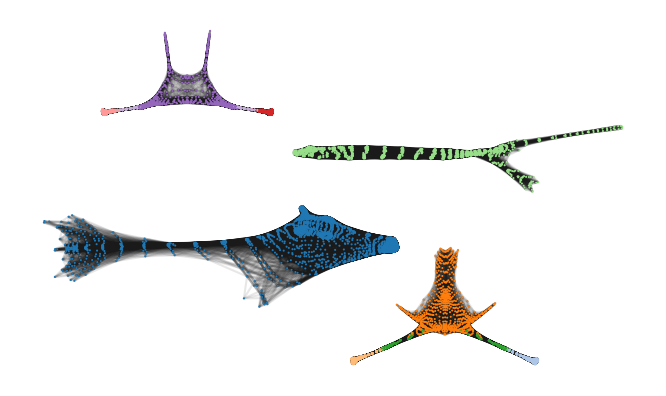

In [12]:
sized_fig(1, aspect=1)
g.plot(edge_alpha=0.1, node_color=[
    palette[l % 20] for l in c.labels_[g.point_mask]
])
frame_off()
plt.show()

These graphs also show how the centrality metric behaves.

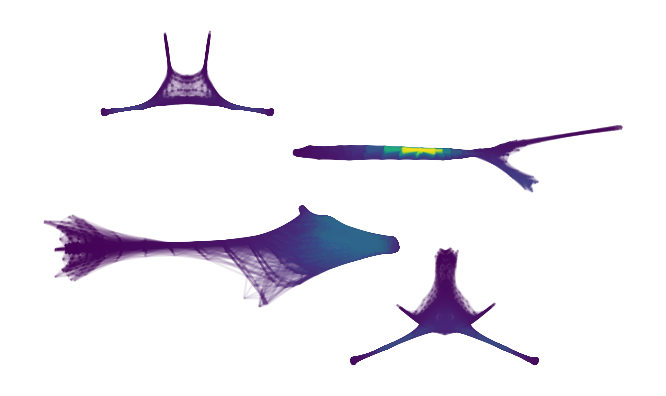

In [13]:
sized_fig(1, aspect=1)
g.plot(node_alpha=0, edge_color='centrality', edge_alpha=0.1)
frame_off()
plt.show()